# Simultaneous Stabilization & Minimization of Chaotic Systems

# Libraries

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from numpy import genfromtxt
import pandas as pd
import random
from math import sin
import copy

In [2]:
# Plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (20, 10)

# Chaotic Time Series Equations

In [3]:
delta = float(10) # Prandtl number
r = float(28)
b = float(8) / 3
h=0.001

rab_fab_a=0.14
rab_fab_g=0.1
rab_fab_dt=0.001

ros_a=0.2
ros_b=0.2
ros_c=6.3 
ros_dt=0.001


def LorenzSim(x,y,z):
  dx_dt = delta * (y - x)
  dy_dt = r * x - y - x * z
  dz_dt = x * y - b * z
  x += dx_dt * h
  y += dy_dt * h
  z += dz_dt * h
  return (x, y, z)

def RabinovichSim(x,y,z):
  dx = y*(z - 1 + x*x) + rab_fab_g*x
  dy = x*(3*z + 1 - x*x) + rab_fab_g * y
  dz = -2*z*(rab_fab_a + x*y)
  x += rab_fab_dt*dx
  y += rab_fab_dt*dy
  z += rab_fab_dt*dz
  return (x, y, z)

def RosslerSim(x,y,z):
  x_dot = -y - z
  y_dot = x + ros_a*y
  z_dot = ros_b + x*z - ros_c*z
  x += (x_dot * ros_dt)
  y += (y_dot * ros_dt)
  z += (z_dot * ros_dt)
  return (x, y, z)

def error_control(i, mx,my,mz, sx, sy, sz):
    # TODO: NORMALIZE ERROR
    error_x = abs(mx - sx)
    error_y = abs(my - sy)
    error_z = abs(mz - sz)
    if(1 > error_x > 0):
        sx = mx
    if(1 > error_y > 0):
        #print('Master signal:{} - Slave signal:{} - Error X:{}'.format(error_y, my, sy))
        sy = my
    if(1 > error_z > 0):
        #print('Master signal:{} - Slave signal:{} - Error X:{}'.format(error_z, mz, sz))
        sz = mz
    return sx, sy, sz

# Kinetic Energy Equation

In [4]:
def kinetic_energy(element, d=''):
    row = np.array([element[0], element[1], element[2]])
    matrix = np.array([[1, 0, 0],
                    [0, 2, 0],
                    [0, 0, 2]])
    column = np.array([[element[0]], [element[1]], [element[2]]])
    hx = np.dot(row, np.dot(matrix, column))*0.5
    return hx[0]

# PSO Minimization Algorithm

In [5]:
W = 0.5
c1 = 0.8
c2 = 0.9
upper_bound = 2000
lower_bound = -1

# PARTICLE FOR LORENZ HAS 3 VARIABLES
class Particle():
    def __init__(self):
        self.position = np.array([
            (-1) ** (bool(random.getrandbits(1))) * random.random()*lower_bound,
            (-1) ** (bool(random.getrandbits(1))) * random.random()*lower_bound, 
            (-1) ** (bool(random.getrandbits(1))) * random.random()*upper_bound
        ])
        self.pbest_position = self.position
        self.pbest_value = float('inf')
        self.velocity = np.array([0, 0, 0])

    def __str__(self):
        print("I am at ", self.position, " meu pbest is ", self.pbest_position)

    def move(self):
        self.position = self.position + self.velocity

class Space():
    def __init__(self, target, target_error, n_particles):
        self.target = target
        self.target_error = target_error
        self.n_particles = n_particles
        self.particles = []
        self.gbest_value = float('inf')
        # 3 VARIABLES FOR LORENZ PARTICLE
        self.gbest_position = np.array(
            [random.random()*lower_bound, random.random()*lower_bound, random.random()*upper_bound])

    def print_particles(self):
        for particle in self.particles:
            particle.__str__()

    def fitness(self, particle):
        row = np.array([particle.position[0], particle.position[1], particle.position[2]])
        matrix = np.array([[1, 0, 0],
                        [0, 2, 0],
                        [0, 0, 2]])
        column = np.array([[particle.position[0]], [particle.position[1]], [particle.position[2]]])
        hx = np.dot(row, np.dot(matrix, column))*0.5
        return hx[0]
    
    def set_pbest(self):
        for particle in self.particles:
            fitness_cadidate = self.fitness(particle)
            if(particle.pbest_value > fitness_cadidate):
                particle.pbest_value = fitness_cadidate
                particle.pbest_position = particle.position
    
    def set_gbest(self):
        for particle in self.particles:
            best_fitness_cadidate = self.fitness(particle)
            if(self.gbest_value > best_fitness_cadidate):
                self.gbest_value = best_fitness_cadidate
                self.gbest_position = particle.position

    def move_particles(self):
        for particle in self.particles:
            global W
            new_velocity = (W*particle.velocity) + (c1*random.random()) * (particle.pbest_position - particle.position) + \
                (random.random()*c2) * (self.gbest_position - particle.position)
            particle.velocity = new_velocity
            particle.move()
    
class PSO():
    """
    PSO Optimization Algorithm
    params
    n_iterations = number of iterations
    target_error = bound of error
    n_particles = num. of particles in the swarm
    """

    def __init__(self, n_iterations, target_error, n_particles):
        self.n_iterations = n_iterations
        self.target_error = target_error
        self.n_particles = n_particles
        self.gbest_dataset = []
    
    def pso_optimization(self):
        search_space = Space(1, self.target_error, self.n_particles)
        particles_vector = [Particle()
                            for _ in range(search_space.n_particles)]
        search_space.particles = particles_vector
        # search_space.print_particles()

        iteration = 0
        while(iteration < self.n_iterations):
            search_space.set_pbest()
            search_space.set_gbest()

            self.gbest_dataset.append(search_space.gbest_value)

            if(abs(search_space.gbest_value - search_space.target) <= search_space.target_error):
                break

            search_space.move_particles()
            iteration += 1

        print("The best solution is: ", search_space.gbest_position,
              " in n_iterations: ", iteration)
              
        return self.gbest_dataset

# Grey Wolves Minimization Algorithm

In [6]:
class wolf:
  def __init__(self, fitness, dim, minx, maxx, seed):
    self.rnd = random.Random(seed)
    self.position = [0.0 for i in range(dim)]
 
    for i in range(dim):
      self.position[i] = ((maxx - minx) * self.rnd.random() + minx)
 
    self.fitness = fitness(self.position) # curr fitness


# grey wolf optimization (GWO)
def gwo(fitness, max_iter, n, dim, minx, maxx):
    rnd = random.Random(0)

    #fitnes values
    fitness_values = []
 
    # create n random wolves
    population = [ wolf(fitness, dim, minx, maxx, i) for i in range(n)]
 
    # On the basis of fitness values of wolves
    # sort the population in asc order
    population = sorted(population, key = lambda temp: temp.fitness)
 
    # best 3 solutions will be called as
    # alpha, beta and gaama
    alpha_wolf, beta_wolf, gamma_wolf = copy.copy(population[: 3])
 
 
    # main loop of gwo
    Iter = 0
    while Iter < max_iter:
 
        # after every 10 iterations
        # print iteration number and best fitness value so far
        if Iter % 10 == 0 and Iter > 1:
            print("Iter = " + str(Iter) + " best fitness = %.6f" % alpha_wolf.fitness)

        # Append Alpha wolf 
        fitness_values.append(alpha_wolf.fitness)
        # linearly decreased from 2 to 0
        a = 2*(1 - Iter/max_iter)
 
        # updating each population member with the help of best three members
        for i in range(n):
            A1, A2, A3 = a * (2 * rnd.random() - 1), a * (
              2 * rnd.random() - 1), a * (2 * rnd.random() - 1)
            C1, C2, C3 = 2 * rnd.random(), 2*rnd.random(), 2*rnd.random()
 
            X1 = [0.0 for i in range(dim)]
            X2 = [0.0 for i in range(dim)]
            X3 = [0.0 for i in range(dim)]
            Xnew = [0.0 for i in range(dim)]
            for j in range(dim):
                X1[j] = alpha_wolf.position[j] - A1 * abs(
                  C1 - alpha_wolf.position[j] - population[i].position[j])
                X2[j] = beta_wolf.position[j] - A2 * abs(
                  C2 -  beta_wolf.position[j] - population[i].position[j])
                X3[j] = gamma_wolf.position[j] - A3 * abs(
                  C3 - gamma_wolf.position[j] - population[i].position[j])
                Xnew[j]+= X1[j] + X2[j] + X3[j]
             
            for j in range(dim):
                Xnew[j]/=3.0
             
            # fitness calculation of new solution
            fnew = fitness(Xnew)
 
            # greedy selection
            if fnew < population[i].fitness:
                population[i].position = Xnew
                population[i].fitness = fnew
                 
        # On the basis of fitness values of wolves
        # sort the population in asc order
        population = sorted(population, key = lambda temp: temp.fitness)
 
        # best 3 solutions will be called as
        # alpha, beta and gaama
        alpha_wolf, beta_wolf, gamma_wolf = copy.copy(population[: 3])
         
        Iter+= 1
    # end-while
 
    # returning the best solution
    return alpha_wolf.position, fitness_values

# Bats Echo-localization Minimization Algorithm

In [7]:
import random 
import numpy as np

class BatAlgorithm():
    def __init__(self, D, NP, N_Gen, A, r, Qmin, Qmax, Lower, Upper, function):
        self.D = D  #dimension
        self.NP = NP  #population size 
        self.N_Gen = N_Gen  #generations
        self.A = A  #loudness
        self.r = r  #pulse rate
        self.Qmin = Qmin  #frequency min
        self.Qmax = Qmax  #frequency max
        self.Lower = Lower  #lower bound
        self.Upper = Upper  #upper bound

        self.f_min = 0.0  #minimum fitness
        
        self.Lb = [0] * self.D  #lower bound
        self.Ub = [0] * self.D  #upper bound
        self.Q = [0] * self.NP  #frequency

        self.v = [[0 for i in range(self.D)] for j in range(self.NP)]  #velocity
        self.Sol = [[0 for i in range(self.D)] for j in range(self.NP)]  #population of solutions
        self.Fitness = [0] * self.NP  #fitness
        self.best = [0] * self.D  #best solution
        self.Fun = function
        self.best_fitness = []


    def best_bat(self):
        i = 0
        j = 0
        for i in range(self.NP):
            if self.Fitness[i] < self.Fitness[j]:
                j = i
        for i in range(self.D):
            self.best[i] = self.Sol[j][i]
        self.f_min = self.Fitness[j]

    def init_bat(self):
        for i in range(self.D):
            self.Lb[i] = self.Lower
            self.Ub[i] = self.Upper

        for i in range(self.NP):
            self.Q[i] = 0
            for j in range(self.D):
                rnd = np.random.uniform(0, 1)
                self.v[i][j] = 0.0
                self.Sol[i][j] = self.Lb[j] + (self.Ub[j] - self.Lb[j]) * rnd
            self.Fitness[i] = self.Fun(self.Sol[i])
        self.best_bat()

    def simplebounds(self, val, lower, upper):
        if val < lower:
            val = lower
        if val > upper:
            val = upper
        return val

    def move_bat(self):
        S = [[0.0 for i in range(self.D)] for j in range(self.NP)]

        self.init_bat()

        for t in range(self.N_Gen):
            for i in range(self.NP):
                rnd = np.random.uniform(0, 1)
                self.Q[i] = self.Qmin + (self.Qmax - self.Qmin) * rnd
                for j in range(self.D):
                    self.v[i][j] = self.v[i][j] + (self.Sol[i][j] -
                                                   self.best[j]) * self.Q[i]
                    S[i][j] = self.Sol[i][j] + self.v[i][j]

                    S[i][j] = self.simplebounds(S[i][j], self.Lb[j],
                                                self.Ub[j])

                rnd = np.random.random_sample()

                if rnd > self.r:
                    for j in range(self.D):
                        S[i][j] = self.best[j] + 0.001 * random.gauss(0, 1)
                        S[i][j] = self.simplebounds(S[i][j], self.Lb[j],
                                                self.Ub[j])
                        
                Fnew = self.Fun(S[i])

                rnd = np.random.random_sample()

                if (Fnew <= self.Fitness[i]) and (rnd < self.A):
                    for j in range(self.D):
                        self.Sol[i][j] = S[i][j]
                    self.Fitness[i] = Fnew

                if Fnew <= self.f_min:
                    for j in range(self.D):
                        self.best[j] = S[i][j]
                    self.f_min = Fnew
                
            self.best_fitness.append(self.f_min)

        # print(self.f_min)
        return(self.best_fitness)

# Energy Minimization with Methaheuritic Algorithms

In [8]:
def fill_dataset(dataset):
    if len(dataset) < 100:
        for _ in range(100 - len(dataset)):
            dataset.append(min(dataset))
    return dataset

def pso_energy_min():
    pso = PSO(100, 0.001, 100)
    min_dataset = pso.pso_optimization()
    graph_dataset_pso = []
    for x in range(len(min_dataset)):
        if(min_dataset[x] < 1.0):
            graph_dataset_pso.append(min_dataset[x])
    return fill_dataset(graph_dataset_pso)

def gw_energy_min():
    dim = 3
    fitness = kinetic_energy
    num_particles = 50
    max_iter = 100
    min_dataset = []
    best_position, min_dataset = gwo(fitness, max_iter, num_particles, dim, -1.0, 200.0)
    graph_dataset_gw = []
    for x in range(len(min_dataset)):
        if(min_dataset[x] < 1.0):
            graph_dataset_gw.append(min_dataset[x])
    return fill_dataset(graph_dataset_gw)

def bats_energy_min():
    Algorithm = BatAlgorithm(3, 100, 100, 0.5, 0.5, 0.0, 2.0, -10.0, 10.0, kinetic_energy)
    min_dataset = Algorithm.move_bat()

    graph_dataset_bat = []
    for x in range(len(min_dataset)):
        if(min_dataset[x] < 1.0):
            graph_dataset_bat.append(min_dataset[x])
    return fill_dataset(graph_dataset_bat)


# Simultaneous Stabilization and Minimization

In [9]:
def control_system(datafile, system_name, control_start, start_size):
  identified_system = pd.read_csv(datafile)
  idx = identified_system['X'].to_list()
  idy = identified_system['Y'].to_list()
  idz = identified_system['Z'].to_list()

  size = start_size

  # initial state of the sub-system
  x1 = random.random() * size * 2 - 1
  y1 = random.random() * size * 2 - 1
  z1 = random.random() * size * 2 - 1

  _x1 = []
  _y1 =[]
  _z1 = []
  
  #Simulation
  time = len(idx)
  time_start = control_start
  for i in range(time):
      # x variable of the driver is chosen as driver signal
      if system_name == 'Lorenz':
        if i < time_start:
          (x1, y1, z1) = LorenzSim(x1, y1 , z1)
        else:
          (x1, y1, z1) = LorenzSim(idx[i], idy[i], idz[i])
          x1, y1, z1 = error_control(i, idx[i], idy[i], idz[i], x1, y1, z1)
      if system_name == 'Rabinovich':
        if i < time_start:
          (x1, y1, z1) = RabinovichSim(x1, y1 , z1)
        else:
          (x1, y1, z1) = RabinovichSim(idx[i], idy[i], idz[i])
          x1, y1, z1 = error_control(i, idx[i], idy[i], idz[i], x1, y1, z1)
      if system_name == 'Rossler':
        if i < time_start:
          (x1, y1, z1) = RosslerSim(x1, y1 , z1)
        else:
          (x1, y1, z1) = RosslerSim(idx[i], idy[i], idz[i])
          x1, y1, z1 = error_control(i, idx[i], idy[i], idz[i], x1, y1, z1)

      _x1.append(x1)
      _y1.append(y1)
      _z1.append(z1)
    
  # Minimization using methaheuristics
  graph_dataset_pso = pso_energy_min()
  graph_dataset_gw = gw_energy_min()
  graph_dataset_bat = bats_energy_min()

  # Stabilization Simulation Graphs
  plt.plot(idx, label='X Signal')
  plt.plot(_x1, label='X Control Signal', linestyle='dashed')
  plt.plot(idy, label='Y Signal')
  plt.plot(_y1, label='Y Control Signal', linestyle='dashed')
  plt.plot(idz, label='Z Signal')
  plt.plot(_z1, label='Z Control Signal', linestyle='dashed')
  plt.xlabel("Time")
  title = f'Control of {system_name} at time {control_start}'
  plt.title(title)
  plt.legend()

  fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
  fig.suptitle(title)
  ax1.plot(idx, label='X Signal')
  ax1.plot(_x1, label='X Control Signal', linestyle='dashed')
  ax1.legend()
  ax2.plot(idy, label='Y Signal')
  ax2.plot(_y1, label='Y Control Signal', linestyle='dashed')
  ax2.legend()
  ax3.plot(idz, label='Z Signal')
  ax3.plot(_z1, label='Z Control Signal', linestyle='dashed')
  ax3.legend()
  ax3.set_xlabel('Time')

  title = f'Error control of {system_name} at time {control_start}'
  x = np.array(idx)
  x1 = np.array(_x1)
  x_loss = x-x1
  y = np.array(idy)
  y1 = np.array(_y1)
  y_loss = y-y1
  z = np.array(idz)
  z1 = np.array(_z1)
  z_loss = z-z1
  fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
  fig.suptitle(title)
  ax1.plot(x_loss)
  ax1.set_ylabel('Error')
  ax2.plot(y_loss)
  ax2.set_ylabel('Error')
  ax3.plot(z_loss)
  ax3.set_ylabel('Error')
  ax3.set_xlabel('Time')
  plt.show()

  # Minimization Graphs
  plt.plot(graph_dataset_pso, label='Min(H) with PSO', scaley='symlog')
  plt.plot(graph_dataset_gw, label='Min(H) with GW', scaley='symlog')
  plt.plot(graph_dataset_bat, label='Min(H) with BAT', scaley='symlog')
  plt.xlabel("Iteration")
  title = f'Energy minimization of {system_name} at {100} iterations'
  plt.title(title)
  plt.legend()
  plt.show()


# Stabilization & Minimization of the chaotic system of Lorenz 63

The best solution is:  [-0.37123164 -0.67077809 -0.07239522]  in n_iterations:  100
Iter = 10 best fitness = 0.009149
Iter = 20 best fitness = 0.000210
Iter = 30 best fitness = 0.000069
Iter = 40 best fitness = 0.000030
Iter = 50 best fitness = 0.000030
Iter = 60 best fitness = 0.000004
Iter = 70 best fitness = 0.000004
Iter = 80 best fitness = 0.000004
Iter = 90 best fitness = 0.000003


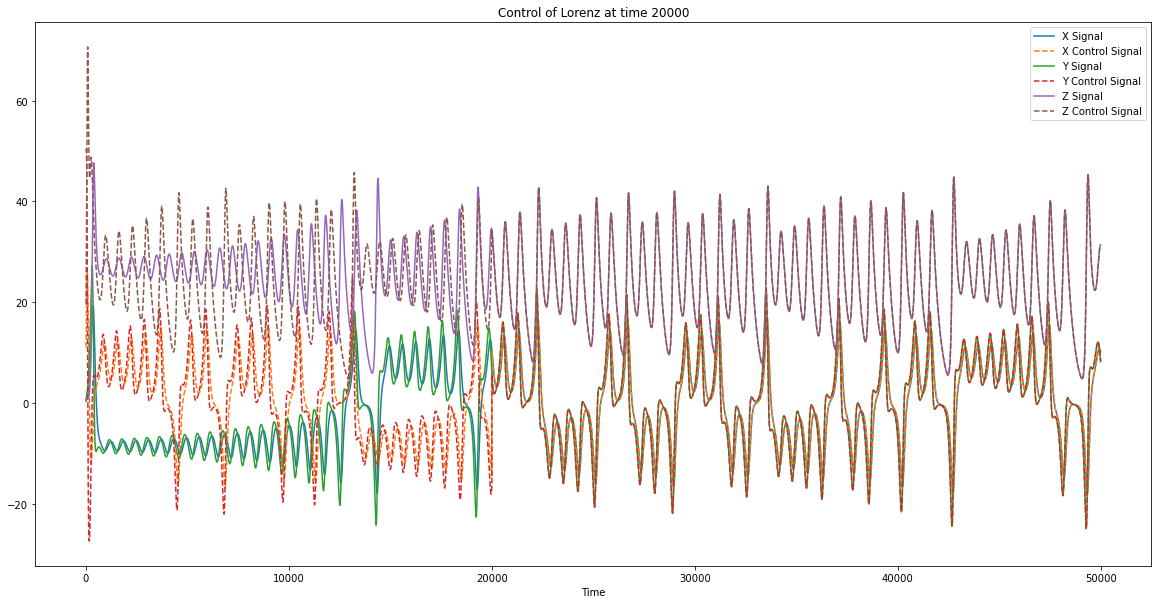

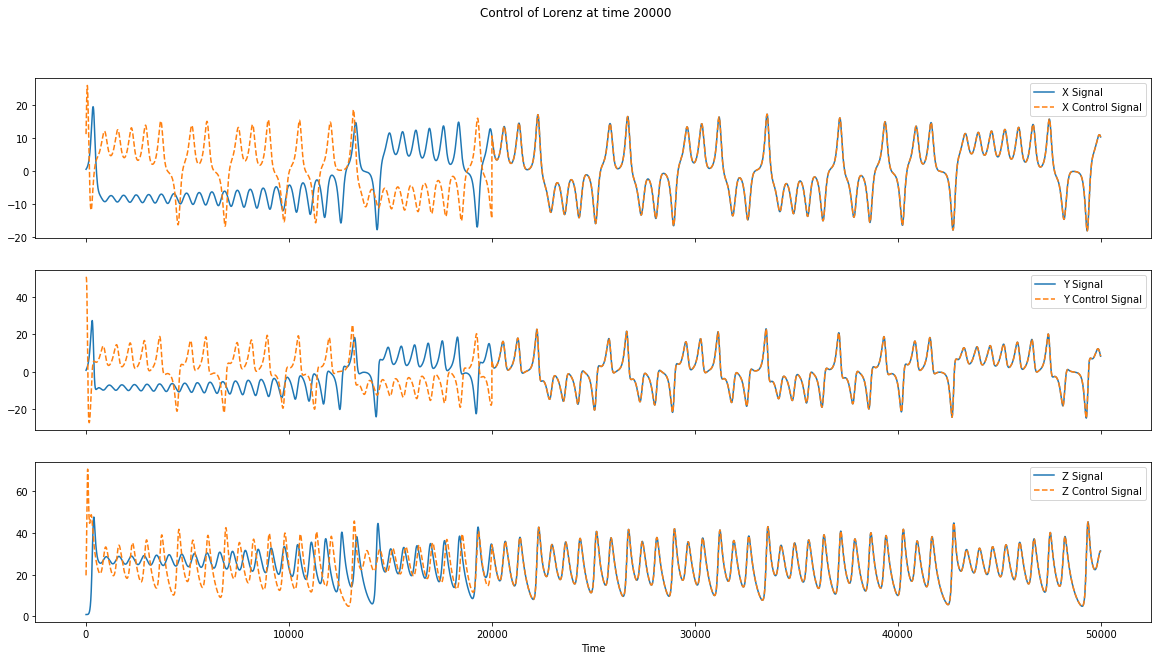

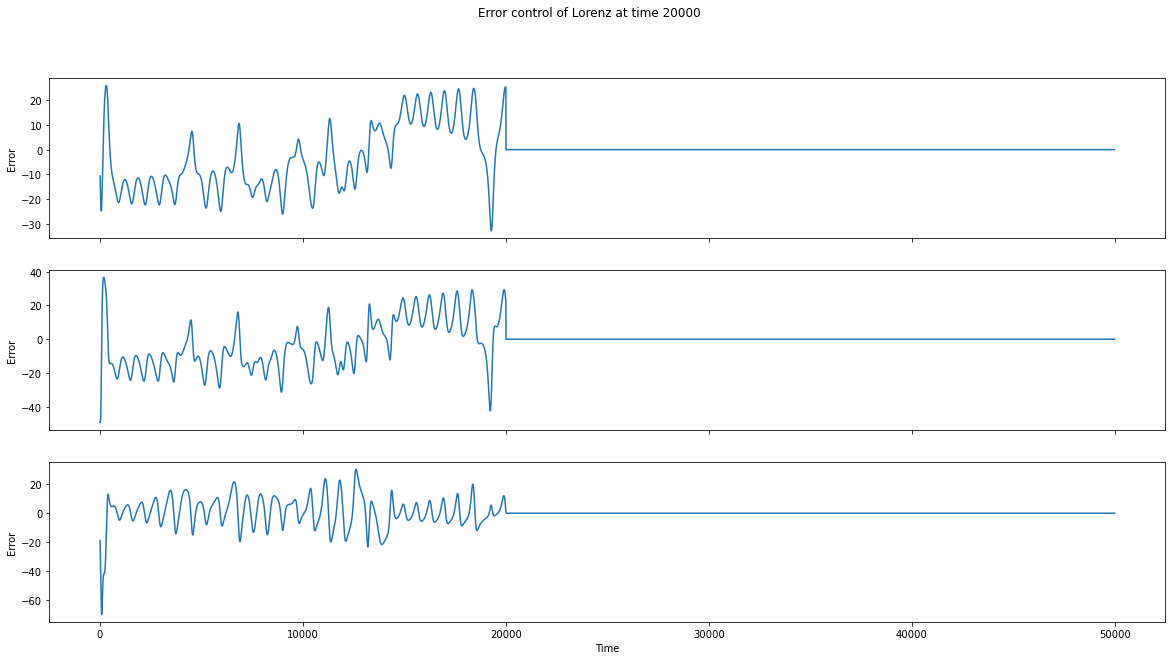

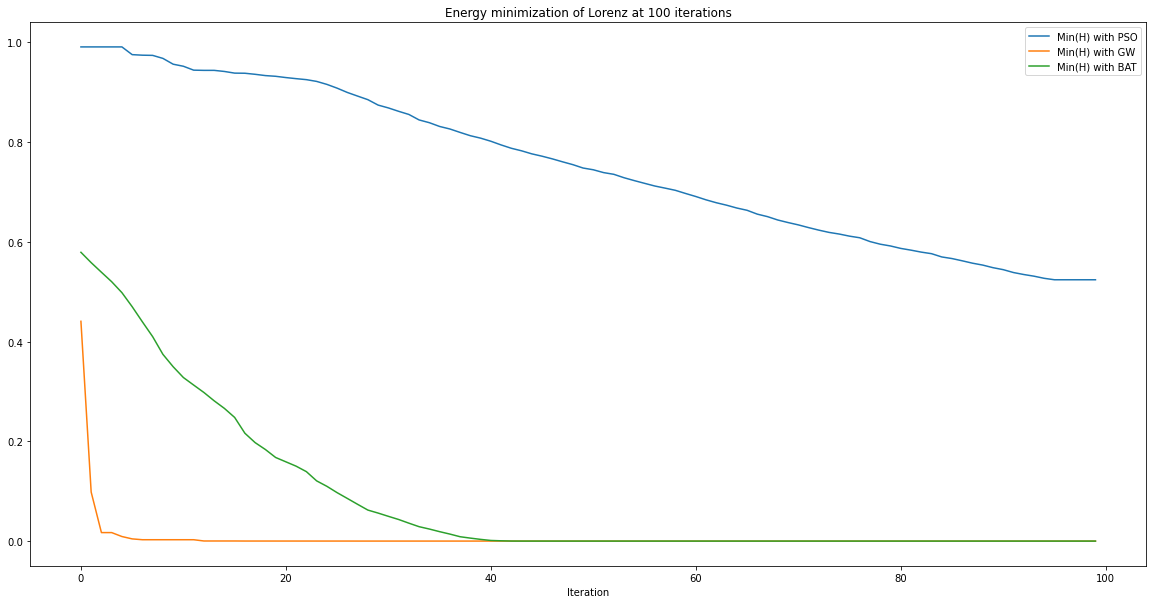

In [10]:
control_system('data/lorenz.csv', 'Lorenz', 20000, 30)

# Stabilization & Minimization of the chaotic system of Rossler

The best solution is:  [-0.06458797  0.53994734  0.01888276]  in n_iterations:  100
Iter = 10 best fitness = 0.009149
Iter = 20 best fitness = 0.000210
Iter = 30 best fitness = 0.000069
Iter = 40 best fitness = 0.000030
Iter = 50 best fitness = 0.000030
Iter = 60 best fitness = 0.000004
Iter = 70 best fitness = 0.000004
Iter = 80 best fitness = 0.000004
Iter = 90 best fitness = 0.000003


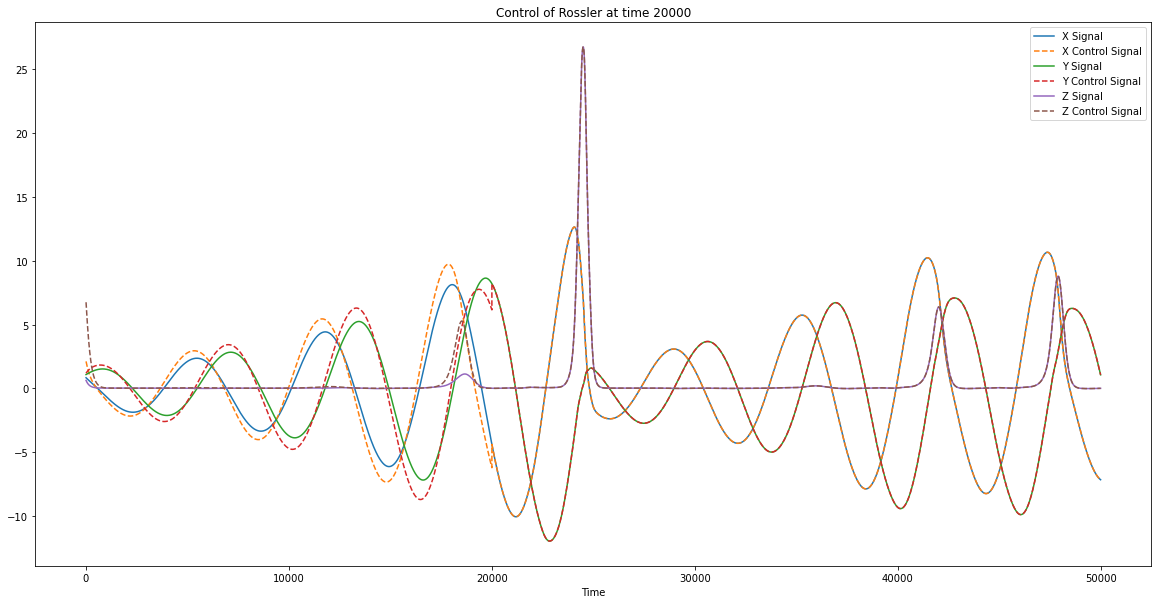

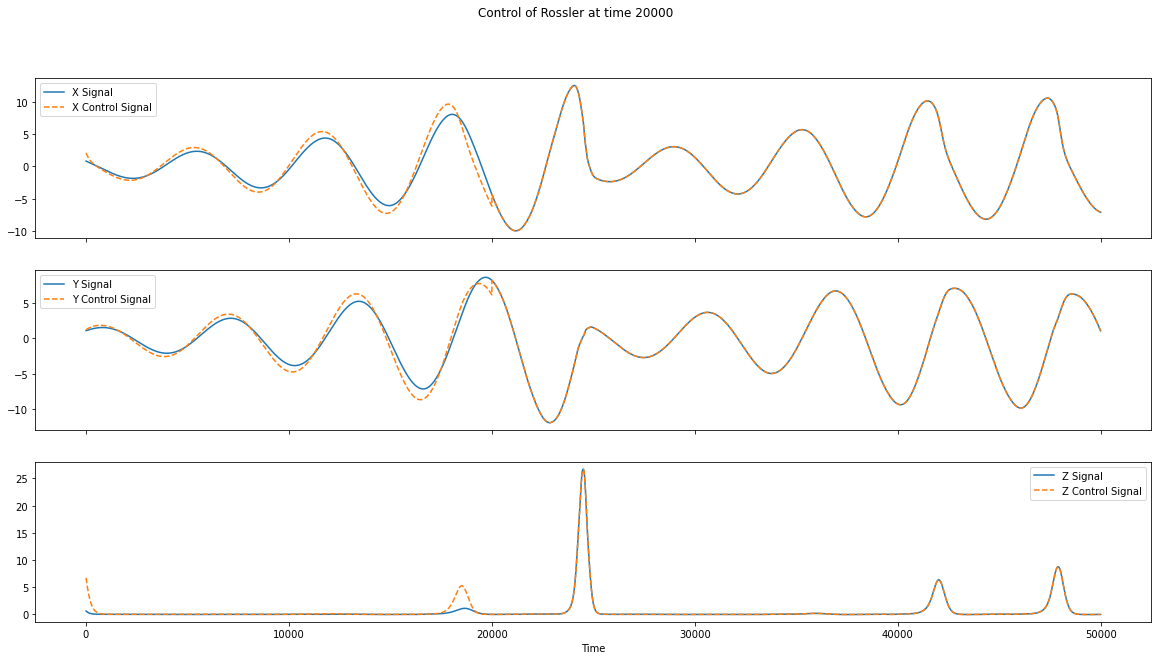

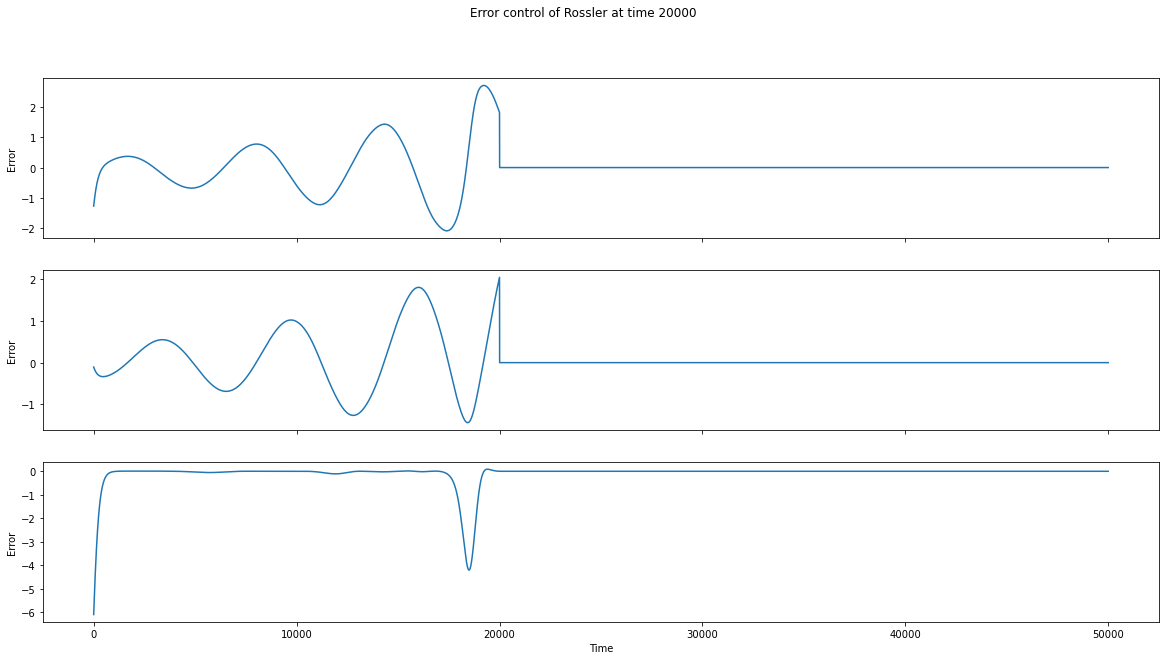

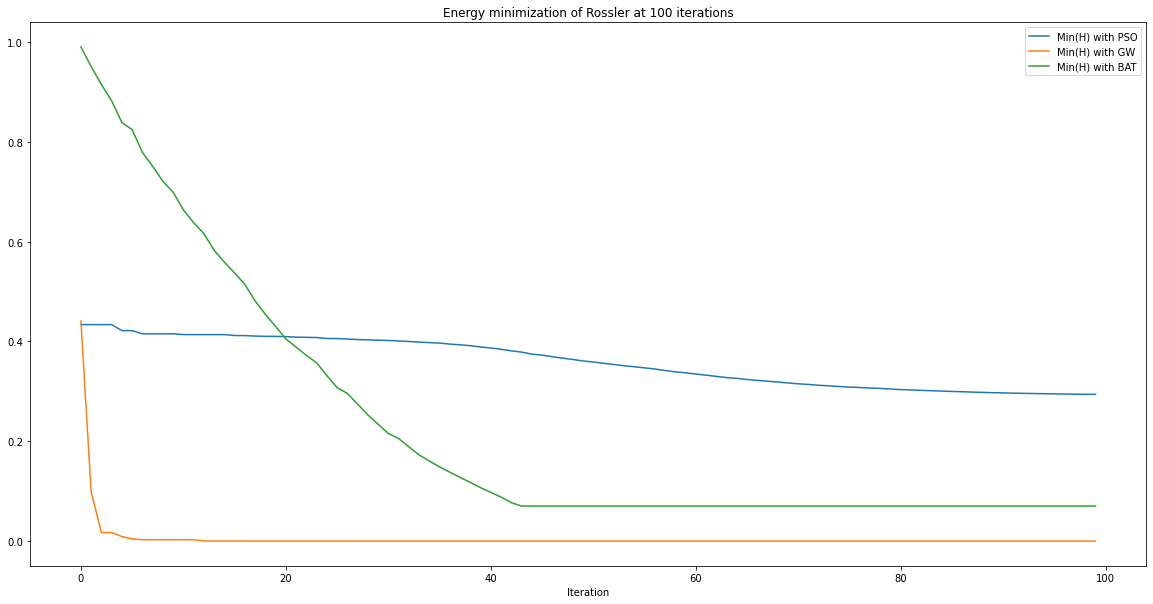

In [11]:
control_system('data/rossler.csv', 'Rossler', 20000, 5)

# Stabilization & Minimization of the chaotic system of Rabinovich-Fabrikant

The best solution is:  [-0.41922106 -0.34439108  0.02375813]  in n_iterations:  100
Iter = 10 best fitness = 0.009149
Iter = 20 best fitness = 0.000210
Iter = 30 best fitness = 0.000069
Iter = 40 best fitness = 0.000030
Iter = 50 best fitness = 0.000030
Iter = 60 best fitness = 0.000004
Iter = 70 best fitness = 0.000004
Iter = 80 best fitness = 0.000004
Iter = 90 best fitness = 0.000003


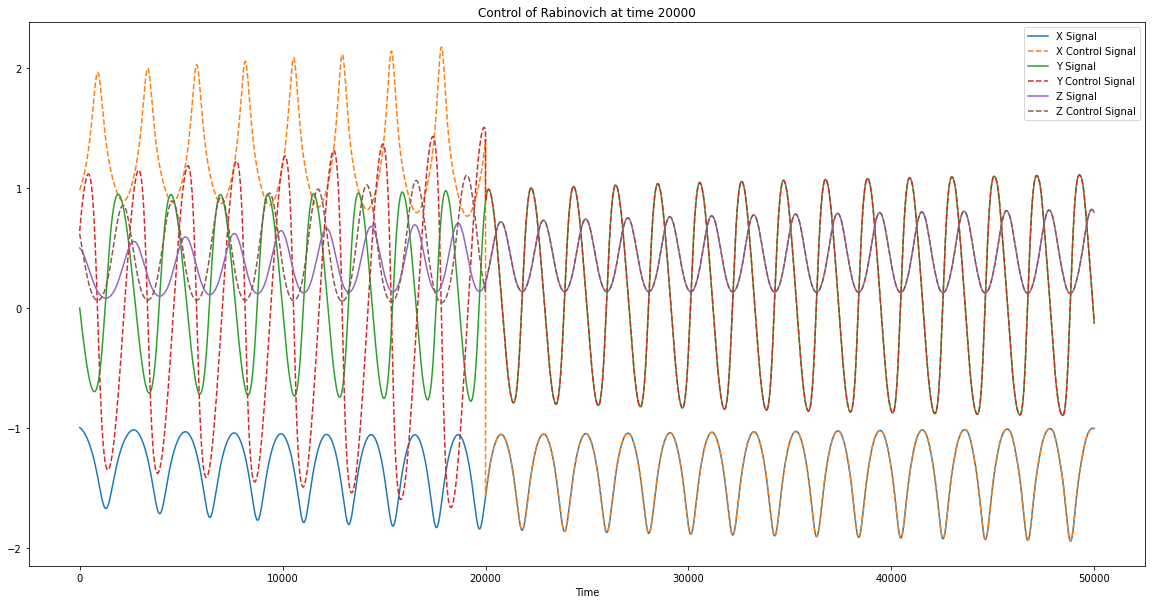

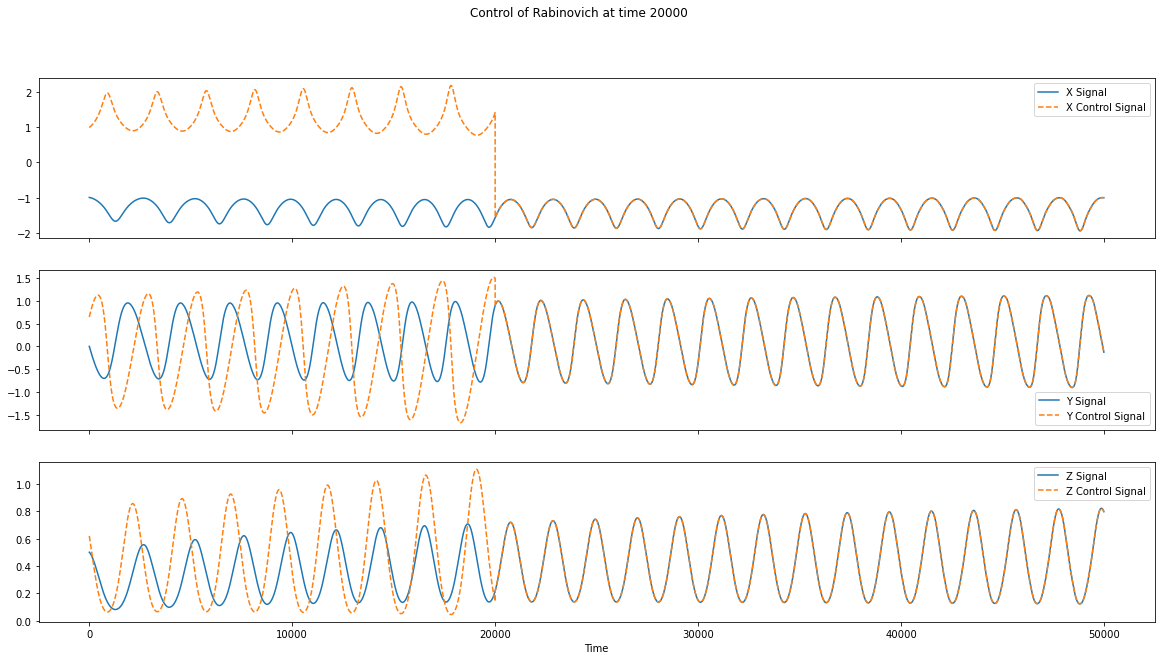

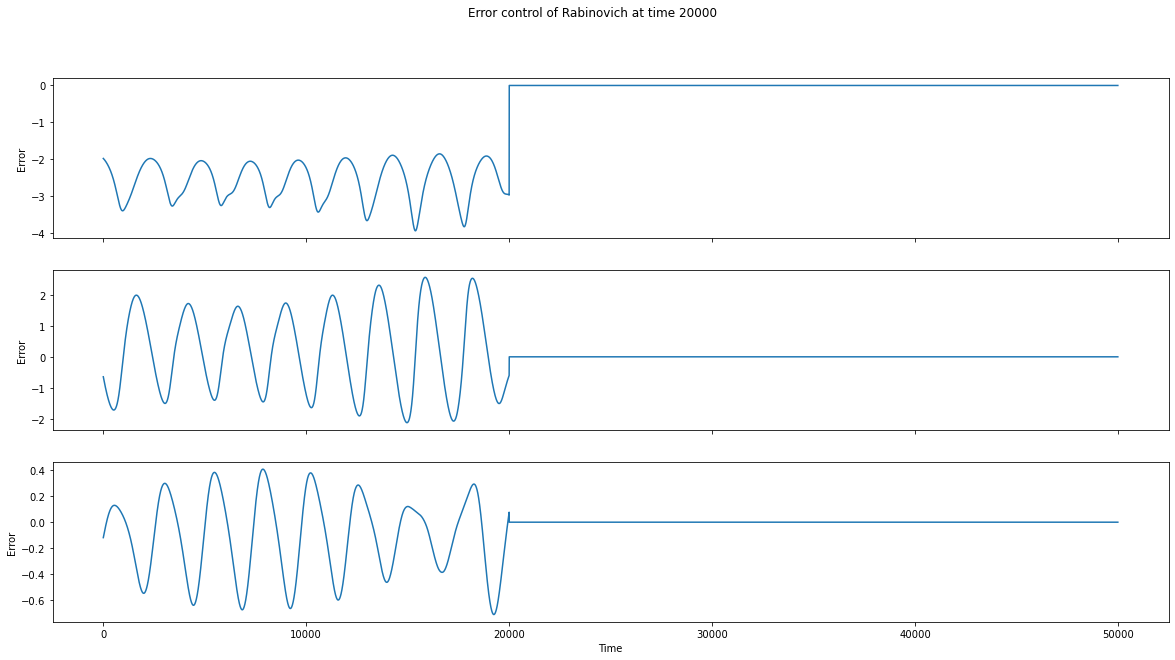

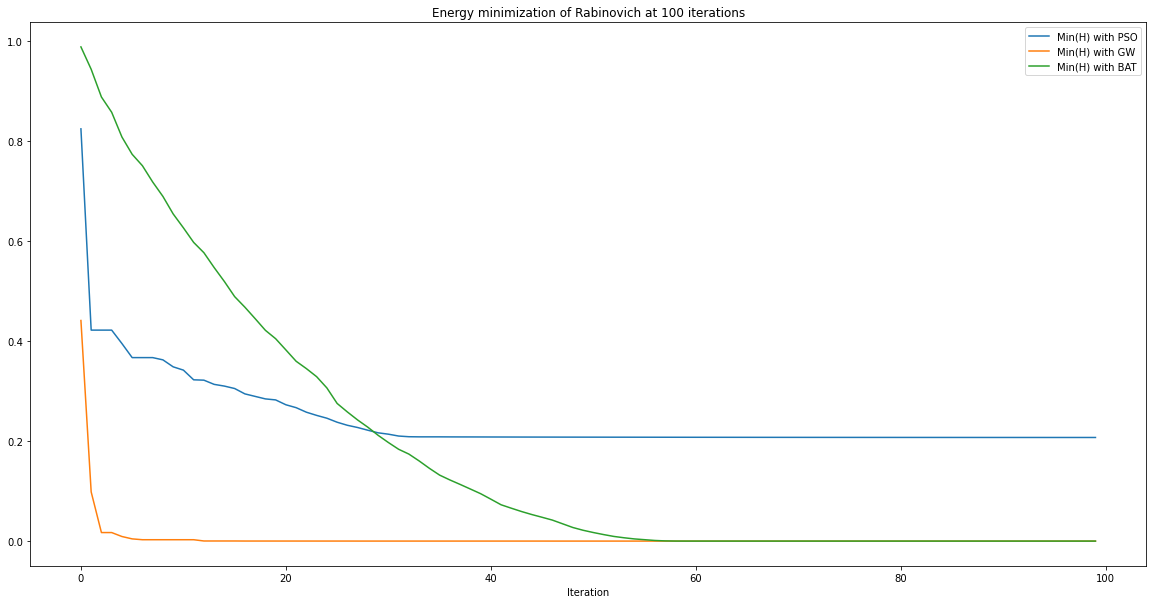

In [12]:
control_system('data/rabinovich.csv', 'Rabinovich', 20000, 1)